This script contains two sections. The frist is a series of scatter plots that show how environmental variables can effect the error of the model data. The second is a series of scatter plots that show correlation between model data and observational data. This script is made so that you can easily view multiple years at once.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [7]:
years=[2015,2016,2017]
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Years: '''+ str(years)))

## Years: [2015, 2016, 2017]

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/


## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [8]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
dictBot=dict()

for Y in years:
    with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictBot[Y]=pickle.load(hh)
        
data=pd.concat(dictBot.values(), ignore_index=True)

In [9]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

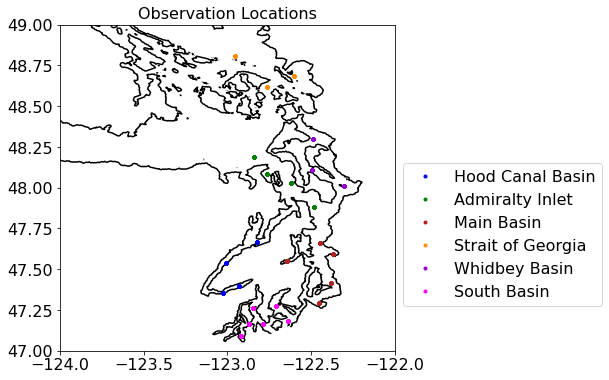

In [10]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)

# When working with multiple years, a for loop is necessary to split things up by months. 
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

These two new dictionaries make it easier to call upon graphs for different years. 

In [11]:
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
datyearreg=dict()
for iyear in datyear:
    datyearreg[iyear]=dict()
    for iregion in datyear[iyear].Basin.unique():
        datyearreg[iyear][iregion]=datyear[iyear].loc[datyear[iyear].Basin==iregion]

In [12]:
def byDepth(ax,obsvar,modvar,lims,byyear = False,year = 'NA'):
    if byyear == False:
        ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    elif byyear == True:
        ps=et.varvarPlot(ax,datyear[year],obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims,year):
    ps=[]
    for ind, iregion in enumerate(data[data.dtUTC.dt.year==year].Basin.unique()):
        ax.plot(datyearreg[year][iregion]['Lon'], datyearreg[year][iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datyearreg[year][iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                            cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

# Error vs environmentable variabls

### Error vs Temperature for years 2015-2017

In [38]:
def multi_env_graph(down,across,figsize,years,envvar,envvar_name):
    fig,ax=plt.subplots(down,across,figsize=figsize)
    for d,Y in zip(range(down),years):
        for a,v in zip(range(across),envvar):
            m=ax[d][a].scatter(datyear[Y][v[0]],datyear[Y][v[1]]-datyear[Y][v[2]],c=datyear[Y]['Z'],s=1,cmap='gnuplot') 
            cb=fig.colorbar(m,ax=ax[d][a],label='Depth (m)')
            ax[d][a].set_xlabel(f'Obs {envvar_name} (g kg$^{-1}$)',fontsize=12)
            ax[d][a].set_ylabel(f'{v[2]} Error ($\mu$M)',fontsize=12)
            ax[d][a].set_title(str(Y))
    plt.tight_layout()

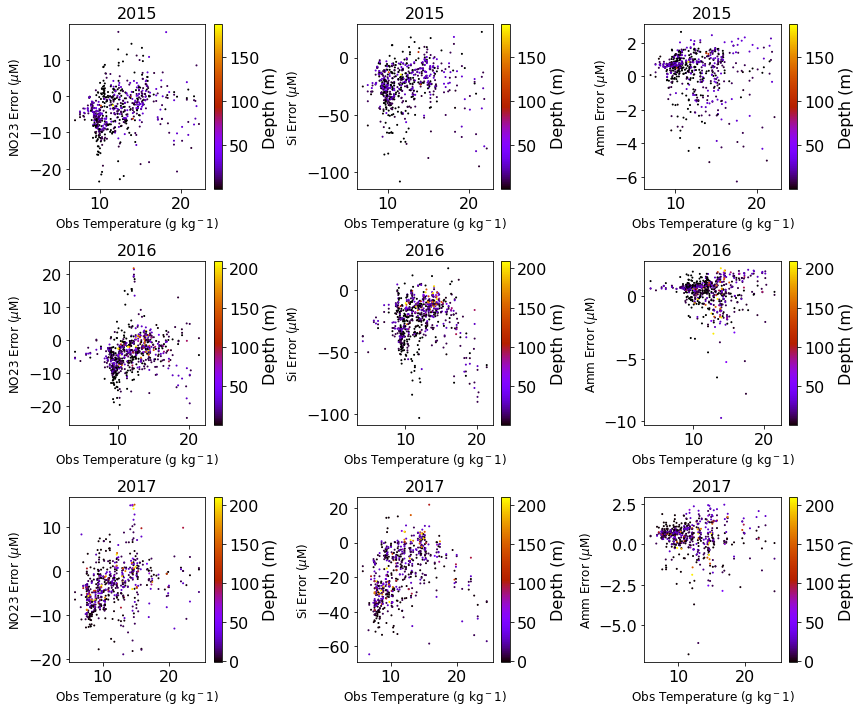

In [39]:
down=3
across=3
figsize=(12,10)
envvar=[['CT','mod_nitrate','NO23'],['CT','mod_silicon','Si'],['CT','mod_ammonium','Amm']]

multi_env_graph(down,across,figsize,years,envvar,'Temperature')

### Error vs Salinity for years 2015-2017

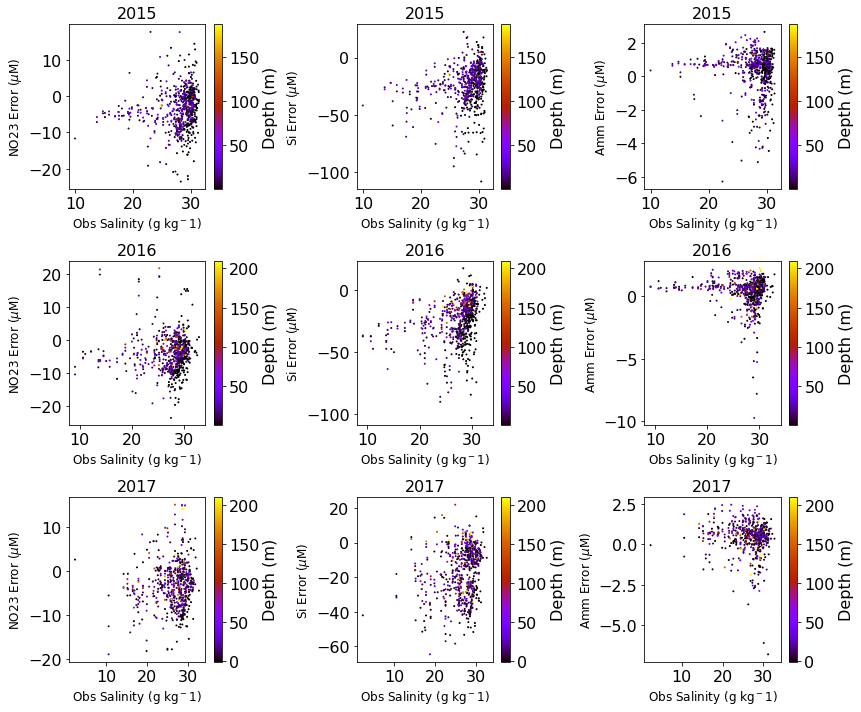

In [15]:
down=3
across=3
figsize=(12,10)
var=[['SA','mod_nitrate','NO23'],['SA','mod_silicon','Si'],['SA','mod_ammonium','Amm']]

multi_env_graph(down,across,figsize,years,var,'Salinity')

### Error vs Latitude for years 2015-2017

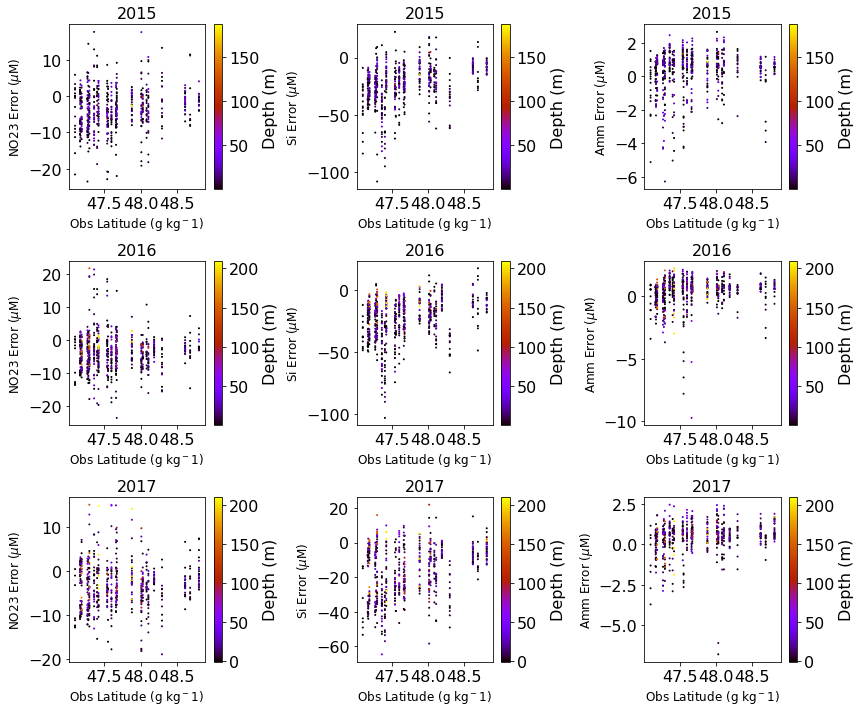

In [16]:
down=3
across=3
figsize=(12,10)
var=[['Lat','mod_nitrate','NO23'],['Lat','mod_silicon','Si'],['Lat','mod_ammonium','Amm']]

multi_env_graph(down,across,figsize,years,var,'Latitude')

## Error vs Depth for years 2015-2017

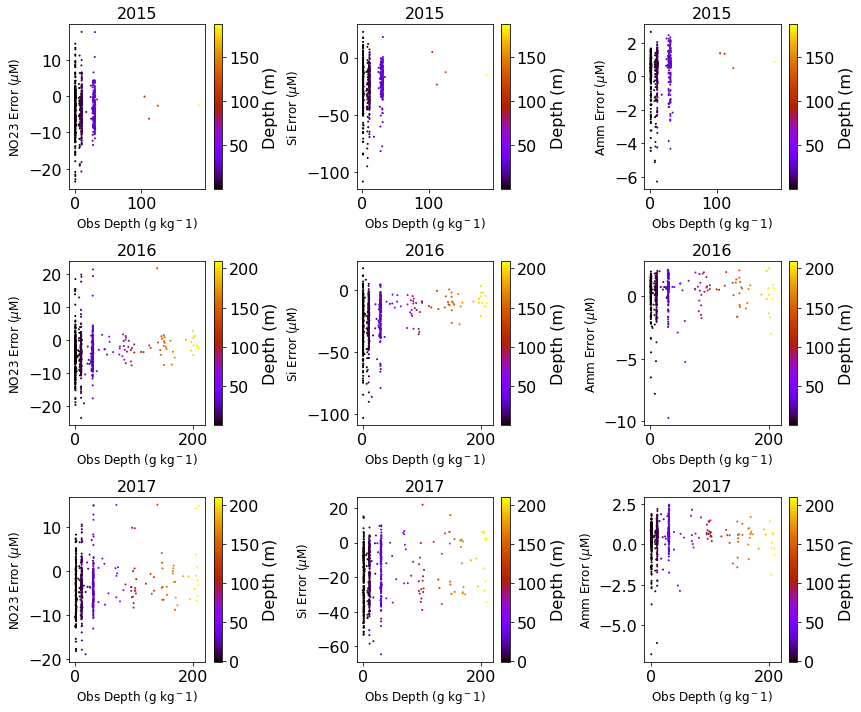

In [17]:
down=3
across=3
figsize=(12,10)
var=[['Z','mod_nitrate','NO23'],['Z','mod_silicon','Si'],['Z','mod_ammonium','Amm']]

multi_env_graph(down,across,figsize,years,var,'Depth')

# Observed Nutrients vs Model Nutrients

## Nitrate 

In [18]:
def multi_depreg_graph(down,figsize,figrange,years,obsvar,modvar,phyvar_name):
    fig,ax=plt.subplots(down,2,figsize=figsize)
    for d,Y in zip(range(down),years):
        ps,l=byDepth(ax[d][0],obsvar,modvar,figrange,byyear=True,year=Y)
        ax[d][0].set_title(f'{phyvar_name} (g kg$^-1$) By Depth for {Y}')
        ps,l=byRegion(ax[d][1],obsvar,modvar,figrange,year=Y)
        ax[d][1].set_title(f'{phyvar_name} (g kg$^-1$) By Region for {Y}');

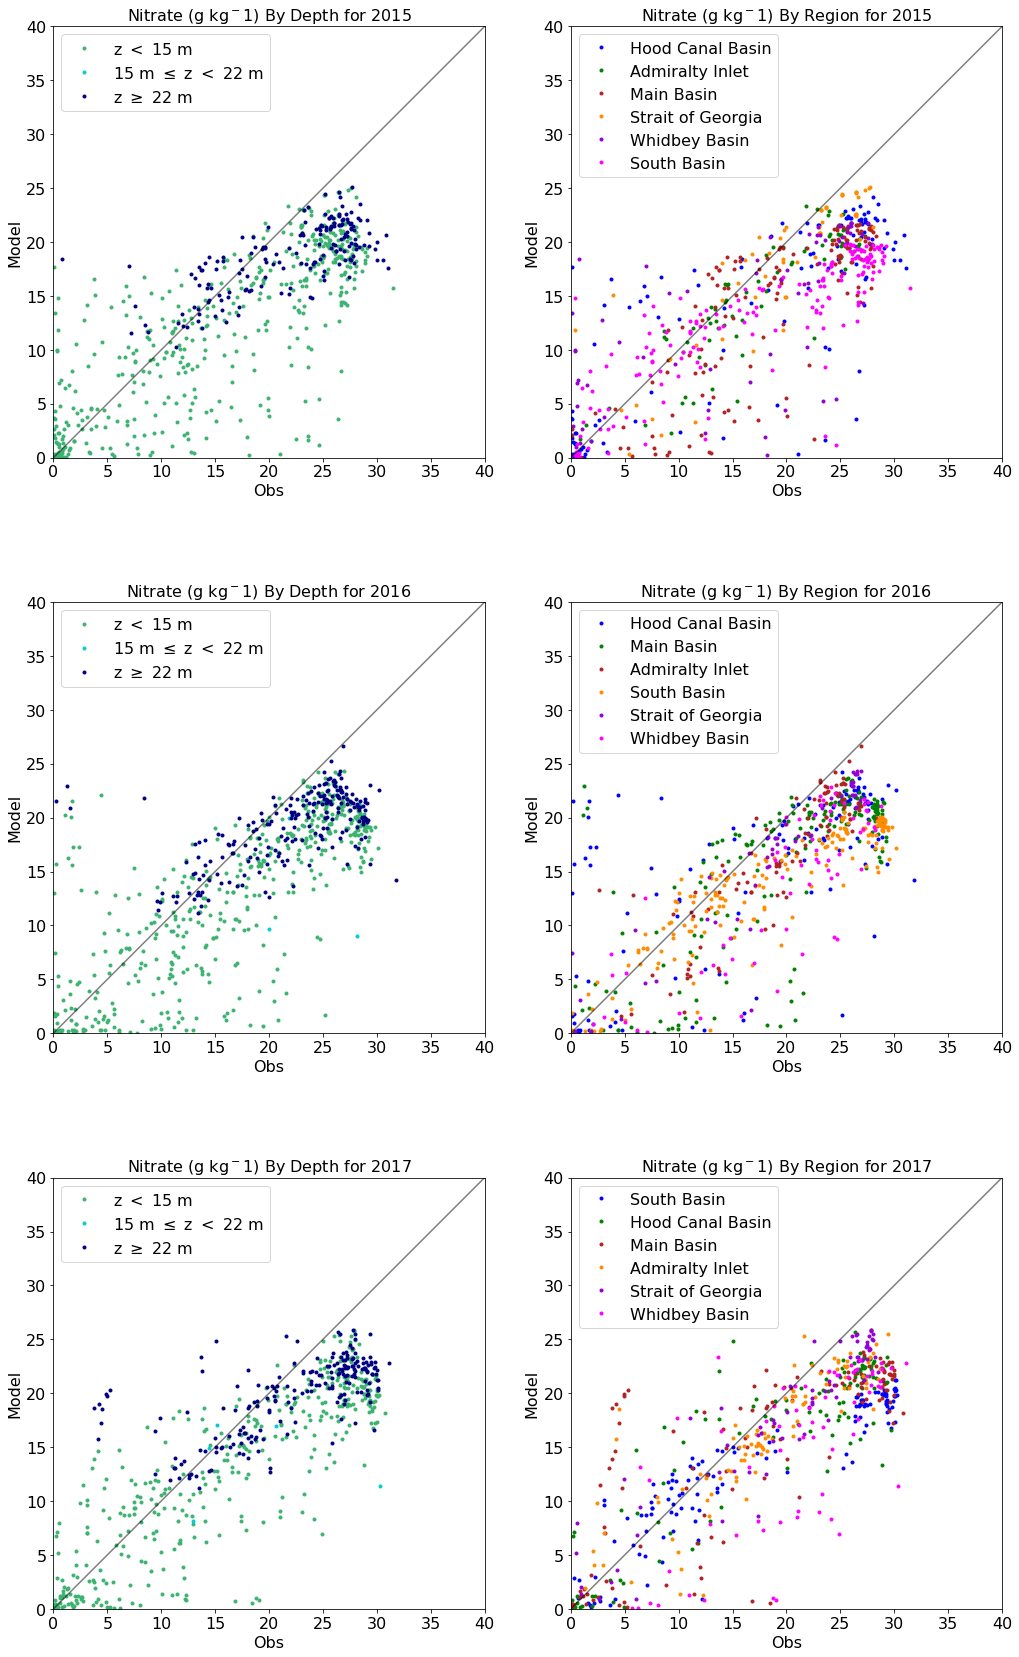

In [19]:
obsvar='NO23'
modvar='mod_nitrate'

multi_depreg_graph(3,(17,30),(0,40),years,obsvar,modvar,'Nitrate')

## Silicon

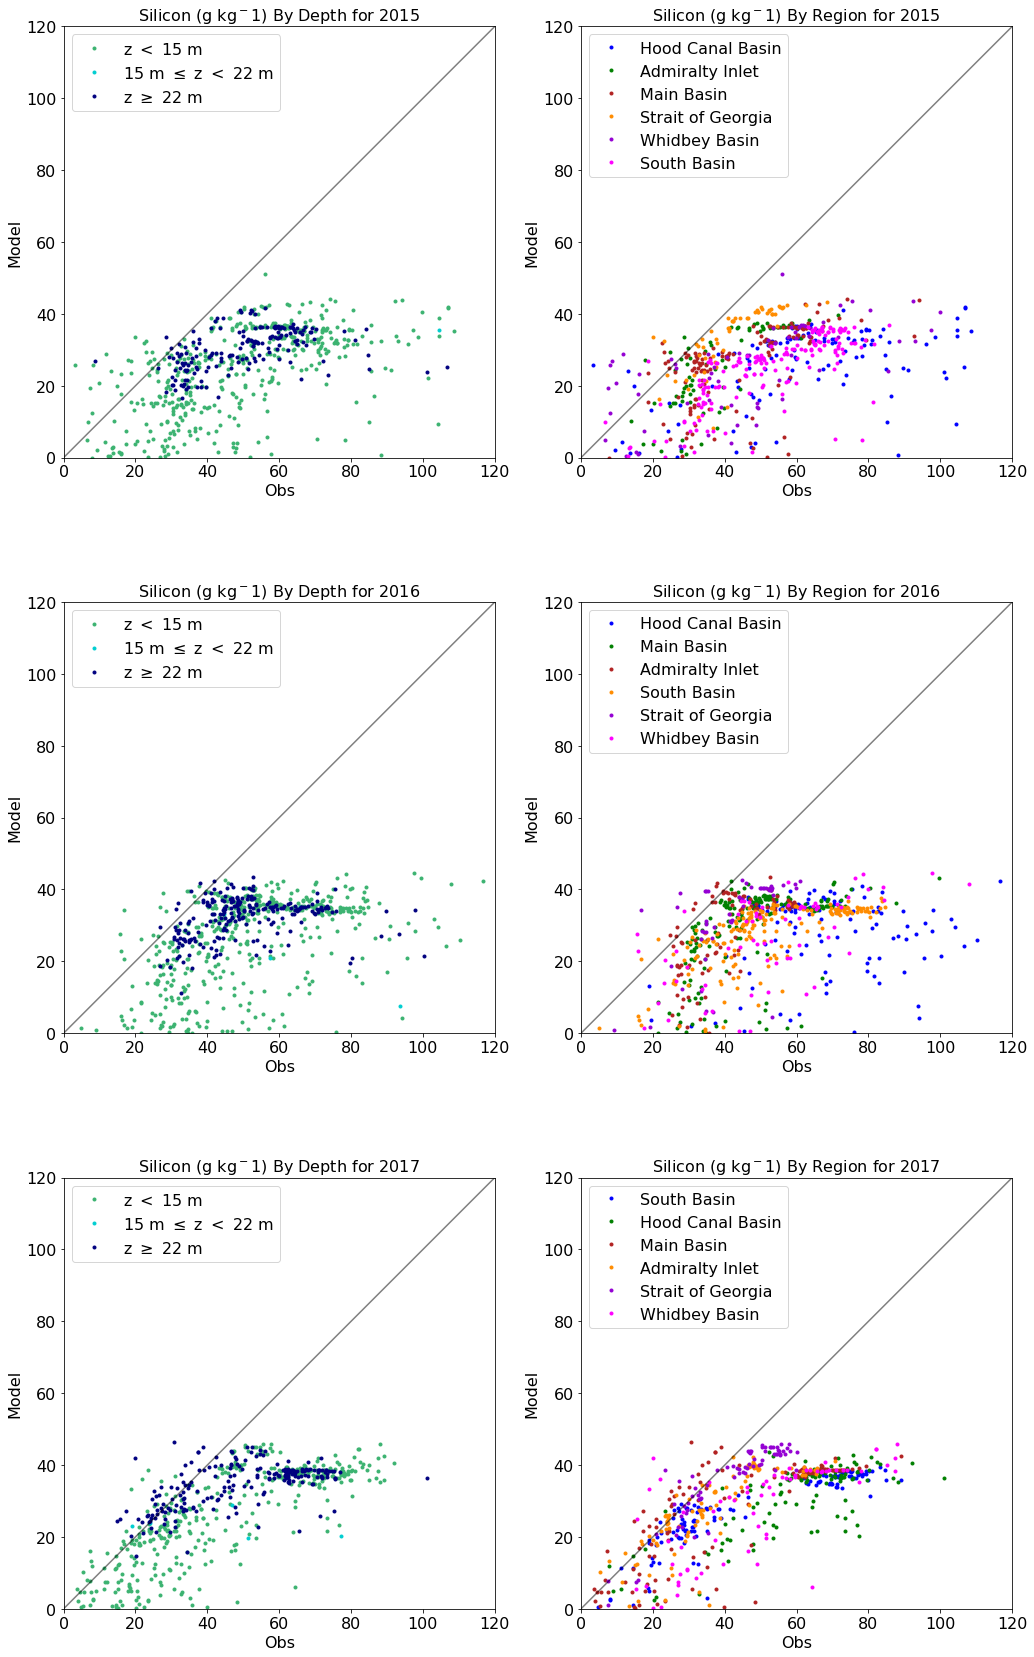

In [20]:
obsvar='Si'
modvar='mod_silicon'

multi_depreg_graph(3,(17,30),(0,120),years,obsvar,modvar,'Silicon')

## Ammonium

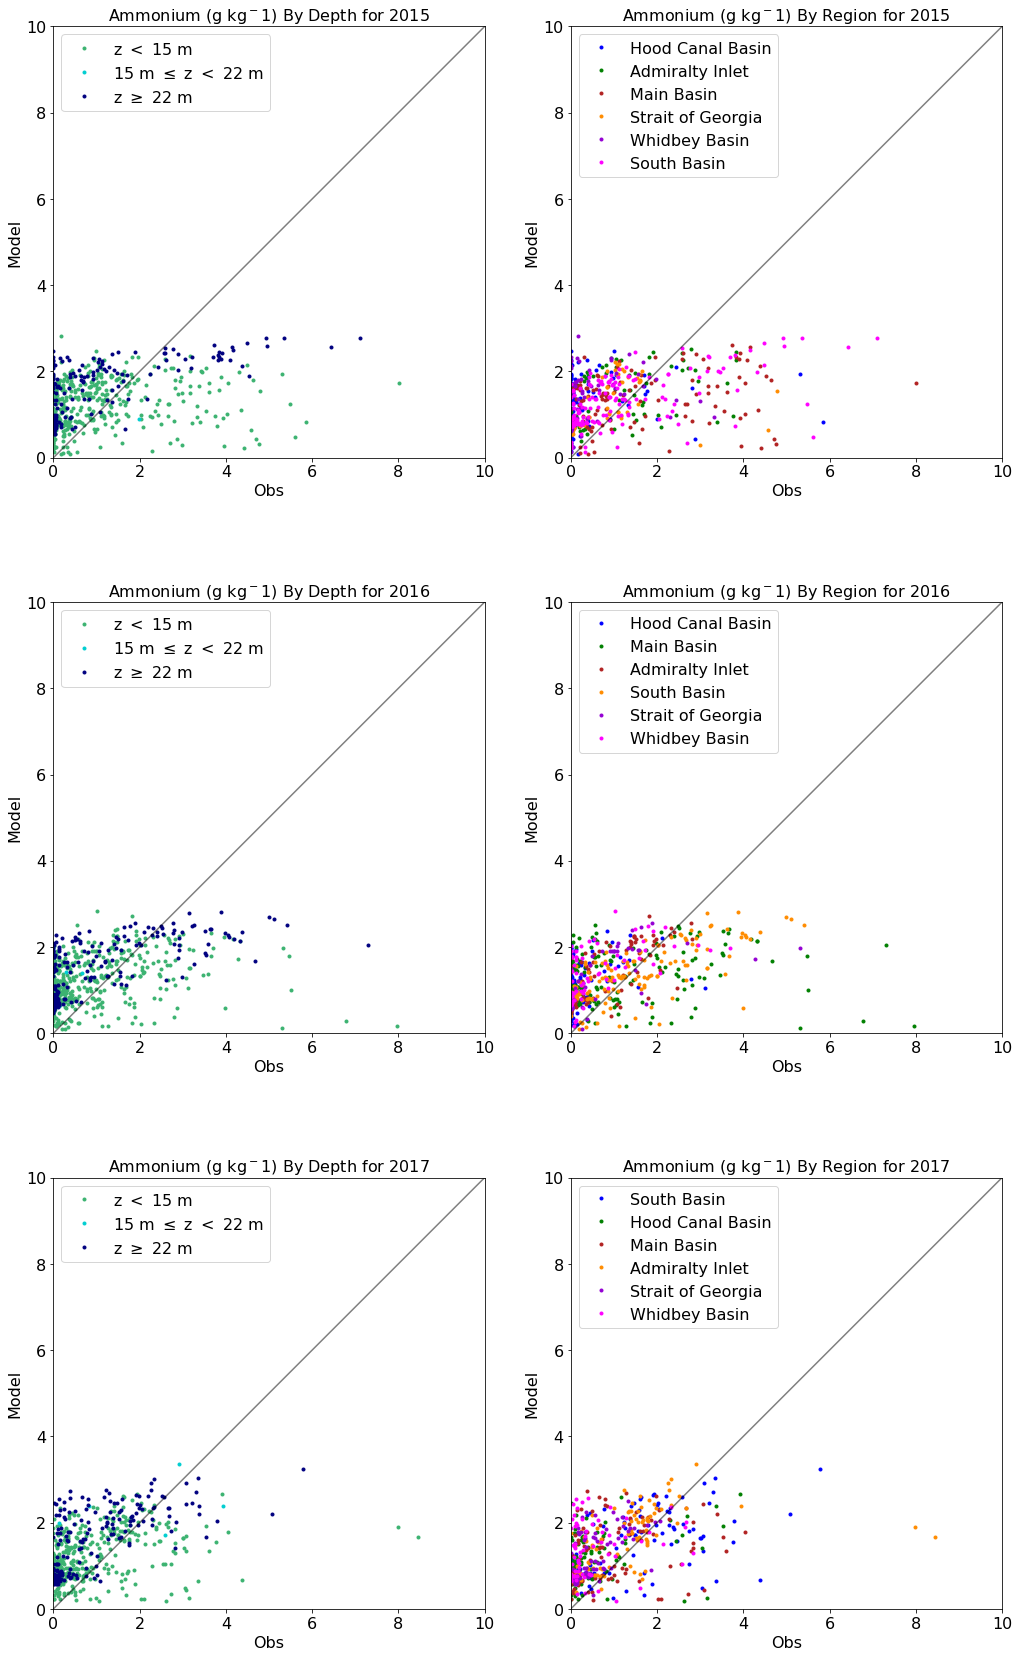

In [21]:
obsvar='Amm'
modvar='mod_ammonium'

multi_depreg_graph(3,(17,30),(0,10),years,obsvar,modvar,'Ammonium')

0
NO23
mod_nitrate
1
Si
mod_silicon


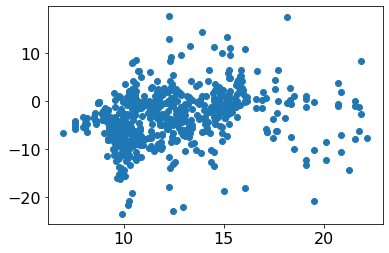

In [43]:
#print((datyear[2015]['NO23']-datyear[2015]['mod_nitrate']).size)
#print(datyear[2015]['CT'].size)
#plt.scatter(datyear[2015]['CT'],datyear[2015]['mod_nitrate']-datyear[2015]['NO23'])
def multi_enverr_graph(df,datyear,years,obsvar,modvar,envvar,envvar_name,figsize):
    if type(years) == int:
        #fig,ax=plt.subplots(1,len(obsvar),figsize=figsize)
        for a,(o,m) in enumerate(zip(obsvar,modvar)):
           m=ax[a].scatter(datyear[years][envvar],datyear[years][modvar]-datyear[years][obsvar],c=datyear[years]['Z'],s=1,cmap='gnuplot')
multi_enverr_graph(data,datyear,2015,['NO23','Si'],['mod_nitrate','mod_silicon'],'CT','Temperature',(15,10))

In [50]:
# This has been altered but it has not been finished or tested !!!!!!!!!!!!!!!
def multi_enverr_graph(df,datyear,years,obsvar,modvar,envvar,envvar_name,figsize):
    if type(years) == int:
        fig,ax=plt.subplots(1,len(obsvar),figsize=figsize)
        for a,(o,m) in enumerate(zip(obsvar,modvar)):
            ps=ax[a].scatter(datyear[years][envvar],datyear[years][m]-datyear[years][o],c=datyear[years]['Z'],s=1,cmap='gnuplot') 
            cb=fig.colorbar(ps,ax=ax[a],label='Depth (m)')
            ax[a].set_xlabel(f'Obs {envvar_name}',fontsize=12)
            ax[a].set_ylabel(f'{o} Error ($\mu$M)',fontsize=12)
            ax[a].set_title(str(years))
    elif type(years) == list:
        fig,ax=plt.subplots(len(years),len(obsvar),figsize=figsize)
        for d,Y in zip(range(len(years)),years):
            for a,(o,m) in enumerate(zip(obsvar,modvar)):
                ps=ax[d][a].scatter(datyear[Y][envvar],datyear[Y][m]-datyear[Y][o],c=datyear[Y]['Z'],s=1,cmap='gnuplot') 
                cb=fig.colorbar(ps,ax=ax[d][a],label='Depth (m)')
                ax[d][a].set_xlabel(f'Obs {envvar_name}',fontsize=12)
                ax[d][a].set_ylabel(f'{o} Error ($\mu$M)',fontsize=12)
                ax[d][a].set_title(str(Y))
    else:
        raise(TypeError('years must be of type list or int'))
    plt.tight_layout()
    
multi_enverr_graph(data,datyear,['NO23','Si'],['mod_nitrate','mod_silicon'],'CT','Temperature',(15,10))



TypeError: years must be of type list or int